In [1]:
import os
from collections import defaultdict
from sklearn.metrics import precision_score, recall_score, f1_score
import json
import numpy as np
import textdistance
import matplotlib.pyplot as plt
import sys
sys.path.append("/Volumes/MyDataDrive/thesis/code-2/src")
import labelrix2


In [2]:
entity_types = ["Email Address", "Invoice Number", "Phone Number", "Contract Number", "Date", "Location", "Organization Name", "Person Name", "Signature"]

tar_chunk_1_unzio_file_path = "/Volumes/MyDataDrive/thesis/code-2/testset-documents-ocr-idp/"


original_label_dir_path = "/Volumes/MyDataDrive/thesis/code-2/src/benchmark-nurips/vishnu-test/labels/"
qwen3_posterior = "/Volumes/MyDataDrive/thesis/code-2/src/weak-labels-algo/Qwen3-30B-A3B/"
qwen3_4b_posterior = "/Volumes/MyDataDrive/thesis/code-2/src/weak-labels-algo/Qwen3-4B/"
qwen2_5_32b_posterior = "/Volumes/MyDataDrive/thesis/code-2/src/weak-labels-algo/Qwen2.5-32B/"
qwen2_5_72b_posterior = "/Volumes/MyDataDrive/thesis/code-2/src/weak-labels-algo/Qwen2.5-72B/"
llama_3_3_70b_posterior = "/Volumes/MyDataDrive/thesis/code-2/src/weak-labels-algo/Llama-3.3-70B/"
gemma_3_4b_posterior = "/Volumes/MyDataDrive/thesis/code-2/src/weak-labels-algo/gemma-3-4b-it/"
gemma_3_27b_posterior = "/Volumes/MyDataDrive/thesis/code-2/src/weak-labels-algo/gemma-3-27b-it/"



In [3]:
def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)
    
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the intersection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [4]:

        
def match_entities(ground_truth, predictions, iou_threshold=0.5):
    tp_value = defaultdict(int)
    fp_value = defaultdict(int)
    fn_value = defaultdict(int)
    tp_bbox = defaultdict(int)
    fp_bbox = defaultdict(int)
    fn_bbox = defaultdict(int)

    gt_dict = defaultdict(list)
    pred_dict = defaultdict(list)

    for entity in ground_truth:
        if isinstance(entity["type"], list):
            gt_dict[entity["type"][0]].append(entity)
        else:
            gt_dict[entity["type"]].append(entity)

    
    for entity in predictions:
        if entity['probability'] >= 0.70:
            if isinstance(entity["pii_type"], list):
                pred_dict[entity["pii_type"][0]].append(entity) 
            else:  
                pred_dict[entity["pii_type"]].append(entity)    

    # Iterate over all entity types present in either ground truth or predictions
    all_entity_types = set(gt_dict.keys()).union(set(pred_dict.keys()))
    for entity_type in all_entity_types:
        ground_truth_entities = gt_dict.get(entity_type, [])
        predicted_entities = pred_dict.get(entity_type, [])

        # Compare values
        # gt_values = {tuple(e["value"]) if isinstance(e["value"], list) else e["value"] for e in ground_truth_entities}
        # pred_values = {tuple(e["value"]) if isinstance(e["value"], list) else e["value"] for e in predicted_entities}

        gt_values = [e["value"] for e in ground_truth_entities]
        pred_values = [e["value"] for e in predicted_entities]

        matched_gt = set()
        matched_pred = set()
        threshold = 0.9

        for i, pred_val in enumerate(pred_values):
            for j, gt_val in enumerate(gt_values):
                if j not in matched_gt:
                    similarity = textdistance.jaro(str(pred_val), str(gt_val))
                    if similarity >= threshold:
                        tp_value[entity_type] += 1
                        matched_gt.add(j)
                        matched_pred.add(i)
                        break

        # tp_value[entity_type] = len(gt_values & pred_values)
        # fp_value[entity_type] = len(pred_values - gt_values)
        # fn_value[entity_type] = len(gt_values - pred_values)

        fp_value[entity_type] = len(pred_values) - len(matched_pred)
        fn_value[entity_type] = len(gt_values) - len(matched_gt)

        # Compare bboxes
        matched_gt = set()
        matched_pred = set()

        # print(f"Count : gt : {len(ground_truth_entities)}, pt  : {len(predicted_entities)}")
        for i, gt_entity in enumerate(ground_truth_entities):
            for j, pred_entity in enumerate(predicted_entities):
                if j not in matched_pred:
                    iou = bb_intersection_over_union(gt_entity["bbox"], pred_entity["bbox"])
                    gt_val = gt_entity["value"]
                    pt_val = pred_entity["value"]
                    # print(f"For gt : {gt_val} pt : {pt_val} iou is : {iou}")
                    if iou >= iou_threshold:
                        tp_bbox[entity_type] += 1
                        matched_gt.add(i)
                        matched_pred.add(j)
                        break

        fn_bbox[entity_type] = len(ground_truth_entities) - len(matched_gt)
        fp_bbox[entity_type] = len(predicted_entities) - len(matched_pred)

    return tp_value, fp_value, fn_value, tp_bbox, fp_bbox, fn_bbox


def match_entities_ignore_type(ground_truth, predictions, threshold=0.85):
    correct_predictions = set()
    matched_gt = set()
    matched_gt_ids = []


    all_gt_ids = []

    for j, gt in enumerate(ground_truth):
        all_gt_ids.append(gt.get("id", j))

    # Two‐pass loop: first exact, then fuzzy
    for pass_type, sim_thresh in [("exact", 1.0), ("fuzzy", threshold)]:
        for i, pred in enumerate(predictions):
            # Skip any preds we already matched in pass 1
            if id(pred) in correct_predictions:
                continue

            pred_val = str(pred["value"]).lower()

            for j, gt in enumerate(ground_truth):
                if j in matched_gt:
                    continue
                gt_val = str(gt["value"]).lower()

                
                sim = textdistance.jaro(pred_val, gt_val)
                print(f"Score : {sim}")
                # Only accept if sim >= our pass’s threshold
                if sim >= sim_thresh:
                    matched_gt.add(j)
                    matched_gt_ids.append(gt.get("id", j))
                    correct_predictions.add(id(pred))
                    print(
                        f"{pass_type.title()}-pass match (thresh={sim_thresh}): "
                        f"pred `{pred_val}` → gt `{gt_val}`, sim={sim:.3f}"
                    )
                    break

    print(f"Matched ground truth IDs: {matched_gt_ids}")
    print(f"Not matched gt ids : {set(all_gt_ids) - set(matched_gt_ids)}")
    return correct_predictions, set(all_gt_ids) - set(matched_gt_ids), all_gt_ids


In [5]:
original_items = os.listdir(original_label_dir_path)

# Here we compute the TP, FP, FN across all the documents for each entity

from collections import defaultdict
import json

# import labelrix.segment_lines

import labelrix2 as labelrix2
import labelrix2.segment_lines

# Create a dictionary to store metrics for multiple models
models_metrics = defaultdict(lambda: {
    'TP_VALUE': defaultdict(int),
    'FP_VALUE': defaultdict(int),
    'FN_VALUE': defaultdict(int),
    'TP_BBOX': defaultdict(int),
    'FP_BBOX': defaultdict(int),
    'FN_BBOX': defaultdict(int),
    'anonymization_ratios': []
})

#  list of model names
models = [
    {'name': 'Qwen3-30B-A3B', 'path': qwen3_posterior},
   # {'name': 'Qwen3-4B', 'path': qwen3_4b_posterior},
   # {"name" : 'qwen2_5_72b', 'path': qwen2_5_72b_posterior},
   # {"name" : 'qwen2_5_32b', 'path': qwen2_5_32b_posterior},
   # {"name" : 'Llama-3.3-70B', 'path': llama_3_3_70b_posterior},
   # {"name": "Gemma3-4B-it", "path": gemma_3_4b_posterior},
   # {"name": "Gemma3-27B-it", "path": gemma_3_27b_posterior}
]

# Function to update metrics for a given model
def update_val(model, tp_values, fp_values, fn_values, tp_bbox, fp_bbox, fn_bbox):
    for entity in entity_types:
        models_metrics[model]['TP_VALUE'][entity] += tp_values[entity]
        models_metrics[model]['FP_VALUE'][entity] += fp_values[entity]
        models_metrics[model]['FN_VALUE'][entity] += fn_values[entity]

        models_metrics[model]['TP_BBOX'][entity] += tp_bbox[entity]
        models_metrics[model]['FP_BBOX'][entity] += fp_bbox[entity]
        models_metrics[model]['FN_BBOX'][entity] += fn_bbox[entity]

# Function to count correctly anonymized entities for a model
def count_correctly_anonymized(tp_value, fn_value):
    correctly_anonymized = 0
    total_entities = 0
    for entity in entity_types:
        correctly_anonymized += tp_value[entity]
        total_entities += tp_value[entity] + fn_value[entity]
    
    return correctly_anonymized, total_entities


cqc_data = defaultdict(list)  # To hold (probability, is_correct) per model

benchmark_file_list_path = "/Volumes/MyDataDrive/thesis/code-2/src/benchmark-file-list.json"
with open(benchmark_file_list_path, "r") as benchmark_file_list_file:
        benchmark_file_list_data = json.load(benchmark_file_list_file)

print(benchmark_file_list_data)
error_review = []

not_matched_gt_count = 0
gt_missed_review_items = []

total_gt_len = 0 
num_matched = 0

# Main loop for processing each model
for model in models:
    model_name = model['name']
    pred_path = model['path']

    for o_item in original_items:
        try:
            ground_truth = load_json(original_label_dir_path + o_item)
            # predicted = load_json(pred_path + o_item)

            # Clean the predicted string if needed
            # predicted = predicted[0]
            # cleaned_json_str = predicted.replace("```json\n", "").replace("\n```", "").strip()
            # predictions = load_predictions(filepath=pred_path +"votes_"+ o_item)
            predictions = load_json(pred_path +"votes_"+ o_item)

            # Get which predictions were correct
            correct_prediction_ids, not_matched_gt_ids, all_gt_ids = match_entities_ignore_type(ground_truth, predictions)
            total_gt_len = total_gt_len + len(all_gt_ids)
            num_matched = num_matched + len(correct_prediction_ids)


            should_include_for_review = False
            not_matched_gt_count = not_matched_gt_count + len(not_matched_gt_ids)
            print("\n\n")            
            print(f"GT JSON : {original_label_dir_path + o_item}")
            print(f"Pred JSON : {pred_path +'votes_'+ o_item}")
            print("\n\n")
            print(f"correct_prediction_ids : {correct_prediction_ids}")

            if len(not_matched_gt_ids) >0:
                page_no = int((original_label_dir_path + o_item).split("_")[-1].split(".")[0][4:])
                page_id = (original_label_dir_path + o_item).split("_")[2].split("/")[-1]

                tar_file_path = tar_chunk_1_unzio_file_path+benchmark_file_list_data[page_id]['file_path']

                for page_n, blocks in labelrix2.segment_lines.load_textract_pages(tar_file_path):
                    # 1) reconstruct segments
                    segments, block_map = labelrix2.segment_lines.extract_line_segments(blocks)
                    pageno = int(page_n.split("page", 1)[1])
                    lines = []

                    if page_no == pageno:
                        for s in segments:
                            lines.append(f"{s['id']}: {s['text']} ({s['token']})")
                        ocr_text_recall = "\n".join(lines)

                        # If some gt is missed
                        gt_r_item = {
                            'ground_truth_file_path':original_label_dir_path + o_item,
                            'predictions_file_path': json.dumps(list(not_matched_gt_ids)),
                            'ocr_text': ocr_text_recall,
                            "pred_file_path": pred_path +"votes_"+ o_item
                        }

                        gt_missed_review_items.append(gt_r_item)
      

            error_predictions = []
            for pred in predictions:
                prob = pred.get("probability", 0)
                if prob >= 0.0 and prob <=1.00:
                    is_correct = id(pred) in correct_prediction_ids
                    cqc_data[model_name].append((prob, is_correct,pred['value'] ,pred['pii_type'], pred['annotators'], o_item ))
                    if not is_correct:
                        should_include_for_review = True
                        error_predictions.append(pred)
                        print(f"ID Gen Not Matched: {id(pred)}")
                        print(pred)

            if should_include_for_review:
                page_no = int((original_label_dir_path + o_item).split("_")[-1].split(".")[0][4:])
                page_id = (original_label_dir_path + o_item).split("_")[2].split("/")[-1]

                tar_file_path = tar_chunk_1_unzio_file_path+benchmark_file_list_data[page_id]['file_path']

                for page_n, blocks in labelrix2.segment_lines.load_textract_pages(tar_file_path):
                    # 1) reconstruct segments
                    segments, block_map = labelrix2.segment_lines.extract_line_segments(blocks)
                    pageno = int(page_n.split("page", 1)[1])
                    lines = []

                    if page_no == pageno:
                        for s in segments:
                            lines.append(f"{s['id']}: {s['text']} ({s['token']})")
                        ocr_text = "\n".join(lines)
                        review_item = {
                            'ground_truth_file_path':original_label_dir_path + o_item,
                            'predictions_file_path': error_predictions,
                            'ocr_text': ocr_text
                        }

                        error_review.append(review_item)


            # Compute TP/FP/FN
            tp_value, fp_value, fn_value, tp_bbox, fp_bbox, fn_bbox = match_entities(
                ground_truth, predictions, iou_threshold=0.5
            )

            # Anonymization Ratio
            correctly_anonymized, total_entities = count_correctly_anonymized(tp_value, fn_value)
            a_ratio = correctly_anonymized / total_entities if total_entities else 1.0
            models_metrics[model_name]['anonymization_ratios'].append(a_ratio)

            # Update Metrics
            update_val(model_name, tp_value, fp_value, fn_value, tp_bbox, fp_bbox, fn_bbox)

            print(f"[{model_name}] Processed {o_item} | Anonymization Ratio: {a_ratio:.2f}")

        except Exception as e:
            print(f"Error for {o_item} with model {model_name}: {e}")
            tp_value = {}
            fp_value = {}
            fn_value = {}

            tp_bbox = {}
            fp_bbox = {}
            fn_bbox = {}
            
            for entity in entity_types:
                tp_value[entity] = 0
                fp_value[entity] = 0
                tp_bbox[entity] = 0
                fp_bbox[entity] = 0

                fn_value[entity] = 0
                fn_bbox[entity] = 0

                for g_T in ground_truth:
                    if g_T['type'] == entity:
                        fn_value[entity] += 1
                        fn_bbox[entity] += 1


            update_val(model_name, tp_value, fp_value, fn_value, tp_bbox, fp_bbox, fn_bbox)




print(len(error_review))
with open("review-items.json","w") as review_item_f:
    json.dump(error_review,review_item_f)

with open("recall_review-items.json","w") as recall_review_item_f:
    json.dump(gt_missed_review_items,recall_review_item_f)


print(f"TOTAL COUNT OF not_matched_gt_count : {not_matched_gt_count}")
print(f"Final Recall : {num_matched / total_gt_len}")

{'fgnn0231': {'pages': [1], 'file_path': 'f/g/n/n/fgnn0231/fgnn0231.json'}, 'fgvd0138': {'pages': [1], 'file_path': 'f/g/v/d/fgvd0138/fgvd0138.json'}, 'fgxw0053': {'pages': [1], 'file_path': 'f/g/x/w/fgxw0053/fgxw0053.json'}, 'fgmp0189': {'pages': [3], 'file_path': 'f/g/m/p/fgmp0189/fgmp0189.json'}, 'fgjy0234': {'pages': [2, 1], 'file_path': 'f/g/j/y/fgjy0234/fgjy0234.json'}, 'fgjc0018': {'pages': [1], 'file_path': 'f/g/j/c/fgjc0018/fgjc0018.json'}, 'fhyx0253': {'pages': [1], 'file_path': 'f/h/y/x/fhyx0253/fhyx0253.json'}, 'fhyg0141': {'pages': [1], 'file_path': 'f/h/y/g/fhyg0141/fhyg0141.json'}, 'fgvg0019': {'pages': [1], 'file_path': 'f/g/v/g/fgvg0019/fgvg0019.json'}, 'fjcx0221': {'pages': [2, 1], 'file_path': 'f/j/c/x/fjcx0221/fjcx0221.json'}, 'fgvv0063': {'pages': [2], 'file_path': 'f/g/v/v/fgvv0063/fgvv0063.json'}, 'fjcc0074': {'pages': [4], 'file_path': 'f/j/c/c/fjcc0074/fjcc0074.json'}, 'fhmb0151': {'pages': [1], 'file_path': 'f/h/m/b/fhmb0151/fhmb0151.json'}, 'fhxh0140': {'page

In [132]:
# Here we calculate precision, recall and F1 score for each entity

from collections import defaultdict

# Final metrics storage for all models
all_model_metrics = {}

for model in models:
    model_name = model['name']
    metric_data = models_metrics[model_name]

    # Get TP, FP, FN for values and bounding boxes
    tp_value = metric_data['TP_VALUE']
    fp_value = metric_data['FP_VALUE']
    fn_value = metric_data['FN_VALUE']

    tp_bbox = metric_data['TP_BBOX']
    fp_bbox = metric_data['FP_BBOX']
    fn_bbox = metric_data['FN_BBOX']

    # Initialize per-entity metric dicts
    metrics_entity_dict = defaultdict(lambda: {'precision': 0.0, 'recall': 0.0, 'f1': 0.0})
    metrics_entity_bbox_dict = defaultdict(lambda: {'precision': 0.0, 'recall': 0.0, 'f1': 0.0})

    print(f"\n--- Metrics for Model: {model_name} ---")

    for entity in entity_types:
        # Text Value Metrics
        tp = tp_value[entity]
        fp = fp_value[entity]
        fn = fn_value[entity]

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0.0

        metrics_entity_dict[entity] = {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'tp': tp,
            'fp': fp,
            'fn': fn
        }

        # Bounding Box Metrics
        tp_b = tp_bbox[entity]
        fp_b = fp_bbox[entity]
        fn_b = fn_bbox[entity]

        precision_box = tp_b / (tp_b + fp_b) if (tp_b + fp_b) > 0 else 0.0
        recall_box = tp_b / (tp_b + fn_b) if (tp_b + fn_b) > 0 else 0.0
        f1_box = (2 * tp_b) / (2 * tp_b + fp_b + fn_b) if (2 * tp_b + fp_b + fn_b) > 0 else 0.0

        metrics_entity_bbox_dict[entity] = {
            'precision': precision_box,
            'recall': recall_box,
            'f1': f1_box
        }

        # Optional: print per-entity
        print(f"\nFor entity ----{entity}-----")
        print(f"Value : Precision={precision:.2f}, Recall={recall:.2f}, F1={f1:.2f}")
        print(f"BBox  : Precision={precision_box:.2f}, Recall={recall_box:.2f}, F1={f1_box:.2f}")

    # Save per-model results
    all_model_metrics[model_name] = {
        'value_metrics': metrics_entity_dict,
        'bbox_metrics': metrics_entity_bbox_dict,
        'anonymization_ratios': metric_data['anonymization_ratios'],
    }



--- Metrics for Model: Qwen3-30B-A3B ---

For entity ----Email Address-----
Value : Precision=0.96, Recall=0.74, F1=0.84
BBox  : Precision=0.89, Recall=0.69, F1=0.78

For entity ----Invoice Number-----
Value : Precision=0.00, Recall=0.00, F1=0.00
BBox  : Precision=0.00, Recall=0.00, F1=0.00

For entity ----Phone Number-----
Value : Precision=0.85, Recall=0.77, F1=0.81
BBox  : Precision=0.83, Recall=0.75, F1=0.78

For entity ----Contract Number-----
Value : Precision=0.61, Recall=0.53, F1=0.57
BBox  : Precision=0.57, Recall=0.49, F1=0.53

For entity ----Date-----
Value : Precision=0.92, Recall=0.71, F1=0.80
BBox  : Precision=0.83, Recall=0.65, F1=0.73

For entity ----Location-----
Value : Precision=0.83, Recall=0.77, F1=0.80
BBox  : Precision=0.82, Recall=0.76, F1=0.79

For entity ----Organization Name-----
Value : Precision=0.69, Recall=0.67, F1=0.68
BBox  : Precision=0.68, Recall=0.66, F1=0.67

For entity ----Person Name-----
Value : Precision=0.94, Recall=0.77, F1=0.85
BBox  : Preci

In [87]:
print(all_model_metrics)
with open("all-model-f1-score.json","w") as all_model_f1_Score_json_file:
    json.dump(all_model_metrics, all_model_f1_Score_json_file)

{'Qwen3-30B-A3B': {'value_metrics': defaultdict(<function <lambda> at 0x107156f20>, {'Email Address': {'precision': 0.9649122807017544, 'recall': 0.7432432432432432, 'f1': 0.8396946564885496, 'tp': 55, 'fp': 2, 'fn': 19}, 'Invoice Number': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'tp': 0, 'fp': 0, 'fn': 13}, 'Phone Number': {'precision': 0.8488372093023255, 'recall': 0.7684210526315789, 'f1': 0.8066298342541437, 'tp': 73, 'fp': 13, 'fn': 22}, 'Contract Number': {'precision': 0.6119402985074627, 'recall': 0.5324675324675324, 'f1': 0.5694444444444444, 'tp': 41, 'fp': 26, 'fn': 36}, 'Date': {'precision': 0.9150326797385621, 'recall': 0.7142857142857143, 'f1': 0.8022922636103151, 'tp': 140, 'fp': 13, 'fn': 56}, 'Location': {'precision': 0.8333333333333334, 'recall': 0.7720588235294118, 'f1': 0.8015267175572519, 'tp': 105, 'fp': 21, 'fn': 31}, 'Organization Name': {'precision': 0.6851851851851852, 'recall': 0.6666666666666666, 'f1': 0.6757990867579908, 'tp': 148, 'fp': 68, 'fn': 74}, 'P

In [133]:
# Here we just display a table like heatmap for each PII type and for the models

import pandas as pd

# Load the JSON file
with open("all-model-f1-score.json", "r") as f:
    model_data = json.load(f)

# Choose which metric to extract: 'value_metrics' or 'bbox_mepoetry adtrics'
metric_type = "value_metrics"  # or 'bbox_metrics'

# Build a nested dictionary: {PII type: {model_name: f1_score}}
f1_scores = {}

for model_name, model_metrics in model_data.items():
    metrics = model_metrics.get(metric_type, {})
    for pii_type, scores in metrics.items():
        f1 = round(scores.get("f1", 0),2)
        if pii_type not in f1_scores:
            f1_scores[pii_type] = {}
        f1_scores[pii_type][model_name] = f1

# Create the DataFrame
df = pd.DataFrame.from_dict(f1_scores, orient="index")

# Sort columns alphabetically (optional)
df = df[sorted(df.columns)]

print(df)

                   Gemma3-27B-it  Gemma3-4B-it  Llama-3.3-70B  Qwen3-30B-A3B  \
Email Address               0.60          0.10           0.58           0.84   
Invoice Number              0.00          0.00           0.00           0.00   
Phone Number                0.65          0.21           0.58           0.81   
Contract Number             0.50          0.22           0.24           0.57   
Date                        0.72          0.47           0.38           0.80   
Location                    0.57          0.19           0.20           0.80   
Organization Name           0.53          0.23           0.23           0.68   
Person Name                 0.64          0.27           0.46           0.85   
Signature                   0.00          0.00           0.00           0.00   

                   Qwen3-4B  qwen2_5_32b  qwen2_5_72b  
Email Address          0.83         0.73         0.00  
Invoice Number         0.00         0.00         0.00  
Phone Number           0.57    

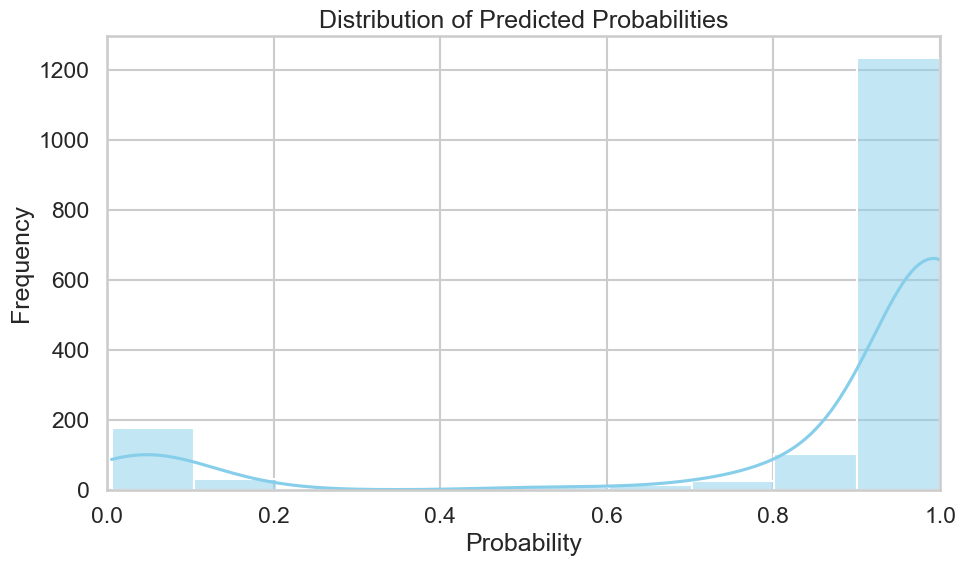

In [134]:
# Here we try to plot the predicted probability distribution
probs = []

for model in models:
    model_name = model['name']
    pred_path = model['path']

    for o_item in original_items:
        try:
            predictions = load_json(pred_path +"votes_"+ o_item)
            for entity in predictions:
                if entity['probability'] > 1000:
                    print(pred_path +"votes_"+ o_item)
                probs.append(entity['probability'])
        except Exception as e:
            print(f"Error for {o_item} with model {model_name}: {e}")

import matplotlib.pyplot as plt
import seaborn as sns

# After collecting all probabilities in `probs` list
plt.figure(figsize=(10, 6))
sns.histplot(probs, kde=True, bins=10, color='skyblue')

plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.xlim(0, 1)  # Ensure x-axis ranges from 0 to 1
plt.grid(True)
plt.tight_layout()
plt.show()

In [135]:
# Define the bins: (0.5, 0.6], (0.6, 0.7], ..., (0.9, 1.0]
probs = np.array(probs)
print(len(probs))

# Define bin edges: [0.5, 0.6, ..., 1.0]
bin_edges = np.arange(0.0, 1.0 + 0.1, 0.1)

# Compute histogram
counts, edges = np.histogram(probs, bins=bin_edges)

# Display
for i in range(len(counts)):
    print(f"({edges[i]}, {edges[i+1]}]: {counts[i]} values")

1605
(0.0, 0.1]: 176 values
(0.1, 0.2]: 33 values
(0.2, 0.30000000000000004]: 0 values
(0.30000000000000004, 0.4]: 1 values
(0.4, 0.5]: 7 values
(0.5, 0.6000000000000001]: 10 values
(0.6000000000000001, 0.7000000000000001]: 15 values
(0.7000000000000001, 0.8]: 25 values
(0.8, 0.9]: 103 values
(0.9, 1.0]: 1233 values


In [11]:
print("Raw data stats:")
print(f"  Min: {probs.min():.4f}")
print(f"  Max: {probs.max():.4f}")
print(f"  Mean: {probs.mean():.4f}")

# Check counts above 1
print("Values > 1:", np.sum(probs > 1))
print("Values > 1000:", np.sum(probs > 1000))
print("Values <= 1:", np.sum(probs <= 1))
print(probs[probs > 1000])

Raw data stats:
  Min: nan
  Max: nan
  Mean: nan
Values > 1: 0
Values > 1000: 0
Values <= 1: 3503
[]


In [12]:
print(f"Min: {probs.min():.4f}, Max: {probs.max():.4f}, Mean: {probs.mean():.4f}")

Min: nan, Max: nan, Mean: nan


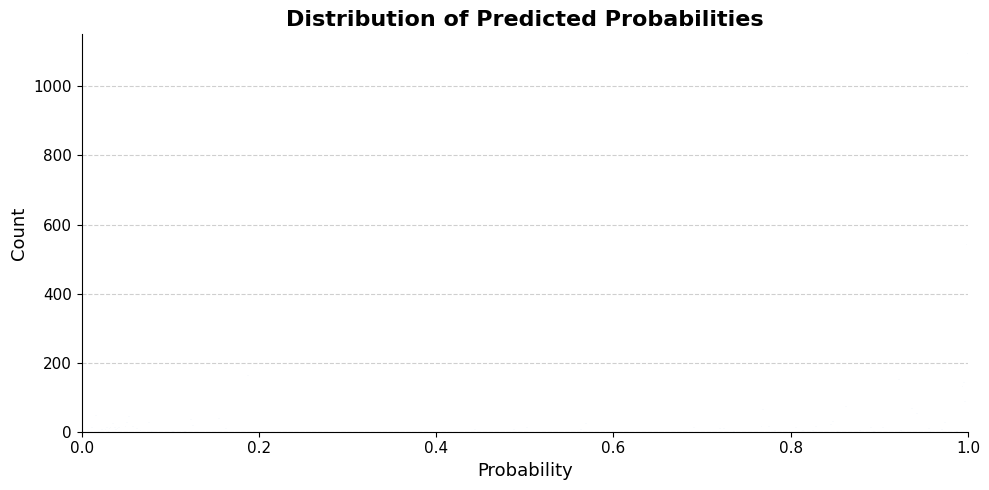

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Create the figure
fig, ax = plt.subplots(figsize=(10, 5))

# Plot histogram with professional binning
n_bins = 1000
ax.hist(probs, bins=n_bins, color='#2A7AB9', edgecolor='white', linewidth=0.8)

# Title and labels
ax.set_title("Distribution of Predicted Probabilities", fontsize=16, fontweight='semibold')
ax.set_xlabel("Probability", fontsize=13)
ax.set_ylabel("Count", fontsize=13)

# Limits and ticks
ax.set_xlim(0, 1)
ax.tick_params(axis='both', labelsize=11)

# Style: clean frame
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# Grid only on y-axis
ax.yaxis.grid(True, linestyle='--', alpha=0.6)
ax.xaxis.grid(False)

# Layout
plt.tight_layout()
plt.show()

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
                    bin  probability  is_correct  count  correct  incorrect
0  (0.0056286, 0.69063]     0.129415    0.438017    242      106        136
1     (0.69063, 0.9414]     0.871947    0.739130    230      170         60
2     (0.9414, 0.99884]     0.991244    0.863636    308      266         42
3    (0.99884, 0.99979]     0.999782    0.928058    139      129         10
4    (0.99979, 0.99982]     0.999822    0.974406    547      533         14
5        (0.99982, 1.0]     0.999906    0.927007    137      127         10
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
               bin  probability  is_correct  count  correct  incorrect
0  (0.0048, 0.154]     0.068012    0.425676    296      126        170
1   (0.154, 0.767]     0.336487    0.245968    248       61        187
2   (0.767, 0.922]     0.858167    0.655977    343      225        118
3   (0.922, 0.994]     0.972238    0.739535    215      159         56
4   (0.994, 0.998]   

/var/folders/g7/2mq549f93f560cdw0f0lx1j40000gn/T/ipykernel_33295/751141376.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")
/var/folders/g7/2mq549f93f560cdw0f0lx1j40000gn/T/ipykernel_33295/751141376.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin")


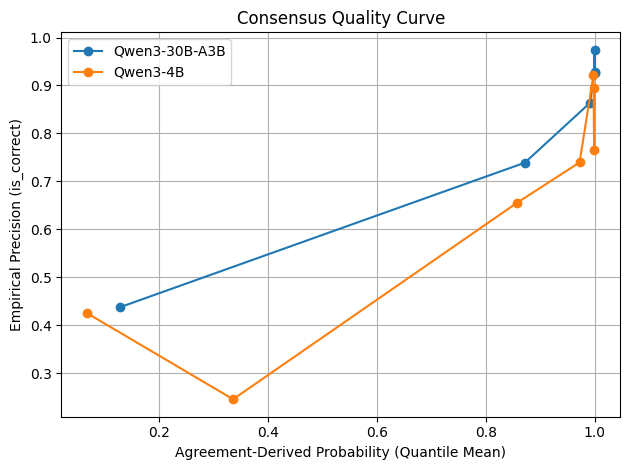

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

for model_name, records in cqc_data.items():
    df = pd.DataFrame(records, columns=["probability", "is_correct", "value", "pii_type", "annotators"])
    df = df[(df["probability"] > 0.0) & (df['pii_type'] != 'Signature')]  # sanity filter
    bins = np.linspace(0, 1, num=11)
    print(bins)
    df["bin"] = pd.qcut(df["probability"], q=7, duplicates="drop")

    curve_df = (
    df
    .groupby("bin")
    .agg(
        probability    = ("probability", "mean"),
        is_correct     = ("is_correct",  "mean"),
        count          = ("probability", "count"),   # total rows per bin
        correct        = ("is_correct",  "sum")      # sum of is_correct = # correct
    )
    .reset_index()
)

    # Now compute “incorrect” without renaming existing columns:
    curve_df["incorrect"] = curve_df["count"] - curve_df["correct"]

    # Sort by the mean‐probability column:
    curve_df = curve_df.sort_values("probability").reset_index(drop=True)

    print(curve_df)

    plt.plot(curve_df["probability"], curve_df["is_correct"], marker='o', label=model_name)

plt.xlabel("Agreement-Derived Probability (Quantile Mean)")
plt.ylabel("Empirical Precision (is_correct)")
plt.title("Consensus Quality Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# sns.set_theme(style="whitegrid")

# for model_name, records in cqc_data.items():
#     # 1) Build DataFrame and apply sanity filter
#     df = pd.DataFrame(records, columns=["probability", "is_correct", "pii_type", "annotators"])
#     df = df[df["probability"] > 0.5]  # only keep p > 0.5

#     # 2) Define fixed-width bins
#     bins = np.linspace(0, 1, num=21)
#     df["bin"] = pd.cut(df["probability"], bins=bins, include_lowest=True)

#     # 3) Aggregate per bin: mean probability, mean accuracy, count, correct, incorrect
#     curve_df = (
#         df
#         .groupby("bin")
#         .agg(
#             probability = ("probability", "mean"),
#             is_correct  = ("is_correct",  "mean"),
#             count       = ("probability", "count"),
#             correct     = ("is_correct",  "sum")
#         )
#         .reset_index()
#     )
#     curve_df["incorrect"] = curve_df["count"] - curve_df["correct"]
#     curve_df = curve_df.sort_values("probability").reset_index(drop=True)

#     # 4) Create two subplots: top for reliability curve, bottom for density shading
#     fig, (ax_curve, ax_density) = plt.subplots(
#         nrows=2,
#         ncols=1,
#         figsize=(8, 6),
#         gridspec_kw={"height_ratios": [3, 1]},
#         sharex=True
#     )

#     # 5) Plot the reliability (consensus‐quality) curve on ax_curve
#     ax_curve.plot(
#         curve_df["probability"],
#         curve_df["is_correct"],
#         marker="o",
#         color="C0",
#         linewidth=2,
#         label=f"{model_name}"
#     )
#     # Optional: plot diagonal reference
#     ax_curve.plot([0, 1], [0, 1], ls="--", color="gray", linewidth=1)
#     ax_curve.set_ylabel("Empirical Accuracy", fontsize=11)
#     ax_curve.set_ylim(0, 1.0)
#     ax_curve.set_title(f"{model_name} – Consensus Quality Curve", fontsize=13, pad=10)
#     ax_curve.grid(True, linestyle=":", alpha=0.7)
#     ax_curve.legend(loc="upper left", fontsize=9)

#     # 6) On ax_density, draw a filled KDE of the probability distribution
#     sns.kdeplot(
#         data=df,
#         x="probability",
#         fill=True,
#         ax=ax_density,
#         color="C1",
#         alpha=0.6,
#         linewidth=1.5
#     )
#     ax_density.set_ylabel("Density", fontsize=11)
#     ax_density.set_xlabel("Predicted Probability", fontsize=11)
#     ax_density.grid(False)

#     # 7) Adjust x‐axis limits to [0.5, 1.0] to match filter (optional)
#     ax_density.set_xlim(0.5, 1.0)

#     plt.tight_layout()
#     plt.show()


# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import statsmodels.api as sm

# # Use a clean Seaborn style
# sns.set_theme(style="whitegrid")

# for model_name, records in cqc_data.items():
#     # 1) Build DataFrame and optionally filter
#     df = pd.DataFrame(records, columns=["probability", "is_correct","value", "pii_type", "annotators",])
#     df = df[df["probability"] > 0.5]  # keep only predictions > 0.5 (adjust as needed)

#     # 2) Fit a LOWESS curve: frac controls the smoothing window (e.g. 0.1 = 10% of data)
#     prob_vals = df["probability"].values
#     is_corr  = df["is_correct"].values
#     lowess_result = sm.nonparametric.lowess(
#         endog=is_corr,
#         exog=prob_vals,
#         frac=0.1,       # adjust between 0.05–0.2 depending on desired smoothness
#         it=0,           # no extra robustifying iterations
#         return_sorted=True
#     )
#     # lowess_result is an array of shape (n_sorted_pts, 2): [ [p_i, smoothed_y_i], ... ]

#     # 3) Create a two‐row plot: top for LOWESS, bottom for KDE
#     fig, (ax_curve, ax_kde) = plt.subplots(
#         nrows=2,
#         ncols=1,
#         figsize=(8, 6),
#         gridspec_kw={"height_ratios": [3, 1]},
#         sharex=True
#     )

#     # 4) Upper panel: scatter of raw points + LOWESS line + diagonal reference
#     ax_curve.scatter(
#         prob_vals,
#         is_corr,
#         s=10,
#         alpha=0.12,
#         color="C1",
#         label="Raw predictions"
#     )
#     ax_curve.plot(
#         lowess_result[:, 0],
#         lowess_result[:, 1],
#         color="C0",
#         linewidth=2.5,
#         label="LOWESS smooth"
#     )
#     ax_curve.plot(
#         [0.5, 1.0],
#         [0.5, 1.0],
#         "--",
#         color="gray",
#         linewidth=1,
#         label="Ideal"
#     )
#     ax_curve.set_ylabel("Empirical Accuracy", fontsize=11)
#     ax_curve.set_ylim(0, 1.0)
#     ax_curve.set_title(f"{model_name} ― Continuous Calibration (LOWESS)", fontsize=13, pad=10)
#     ax_curve.legend(loc="upper left", fontsize=9)
#     ax_curve.grid(True, linestyle=":", alpha=0.6)

#     # 5) Lower panel: KDE of predicted probabilities
#     sns.kdeplot(
#         data=df,
#         x="probability",
#         fill=True,
#         ax=ax_kde,
#         color="C2",
#         alpha=0.3,
#         linewidth=1.5,
#         clip=(0.5, 1.0)
#     )
#     ax_kde.set_ylabel("Density", fontsize=11)
#     ax_kde.set_xlabel("Predicted Probability", fontsize=11)
#     ax_kde.set_xlim(0.5, 1.0)
#     ax_kde.grid(False)

#     # 6) Final formatting
#     plt.tight_layout()
#     plt.show()

[0.  0.2 0.4 0.6 0.8 1. ]

=== Qwen3-30B-A3B Consensus Quality Curve ===
   probability  is_correct  count  lower_wilson  upper_wilson
0          NaN         NaN      0           NaN           NaN
1     0.267049    0.419048    210      0.354355      0.486649
2     0.538166    0.562500     32      0.393256      0.718347
3     0.625000    0.617021    141      0.534691      0.693145
4     0.934401    0.932787   1220      0.917335      0.945522


/var/folders/g7/2mq549f93f560cdw0f0lx1j40000gn/T/ipykernel_33295/87902031.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = df.groupby("bin_raw", group_keys=False) \
/var/folders/g7/2mq549f93f560cdw0f0lx1j40000gn/T/ipykernel_33295/87902031.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=min(len(g), n_per_bin), random_state=42))
/var/folders/g7/2mq549f93f560cdw0f0lx1j40000gn/T/ipykernel_33295/87902031.py:44: FutureWarning: The default of observed=False is deprecated and 

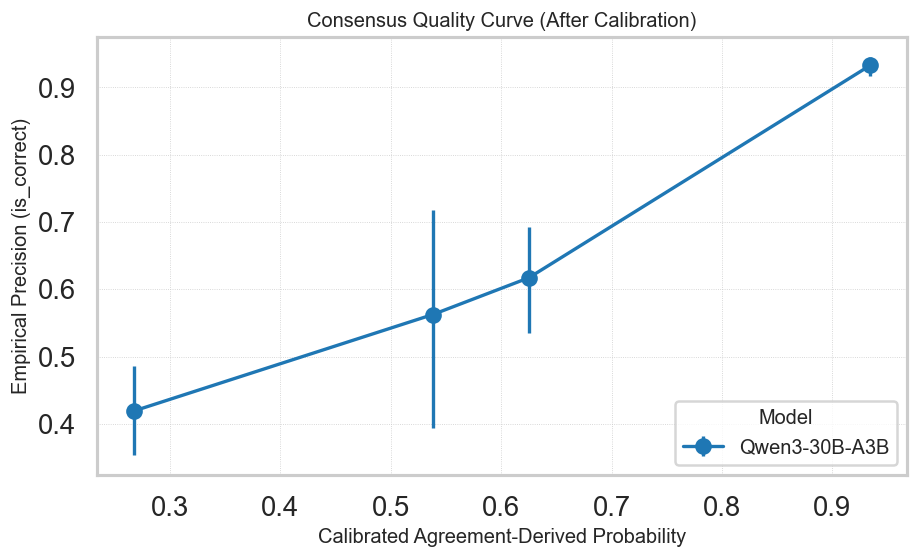

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve
from statsmodels.stats.proportion import proportion_confint  # for Wilson


# Configuration
n_calib_bins = 6     # for initial stratified sampling
n_per_bin     = 40
n_plot_bins   = 2      # number of bins in final quality curve
plot_bins     = np.arange(0.0, 1.0001, 0.2)  # fixed-width
print(plot_bins)
# Prepare a distinct color for each model
palette = sns.color_palette("tab10", n_colors=len(cqc_data))

plt.figure(figsize=(8, 5), dpi=120)

for (model_name, records), color in zip(cqc_data.items(), palette):
    # 1) Build the full dataframe
    df = pd.DataFrame(records, columns=[
        "probability", "is_correct", "value", "pii_type", "annotators"
    ])
    df = df[(df["probability"] > 0.0) & (df["pii_type"] != "Signature")]

    # 2) Stratified sampling for calibration
    df["bin_raw"] = pd.qcut(df["probability"], q=n_calib_bins, duplicates="drop")
    calib = df.groupby("bin_raw", group_keys=False) \
              .apply(lambda g: g.sample(n=min(len(g), n_per_bin), random_state=42))
    q_calib = calib["probability"].values
    y_calib = calib["is_correct"].values

    # 3) Fit isotonic calibrator
    iso = IsotonicRegression(out_of_bounds="clip")
    iso.fit(q_calib, y_calib)

    # 4) Apply calibration to all predictions
    df["prob_calib"] = iso.transform(df["probability"].values)

    # 5) Build final quality curve in fixed-width bins
    df["bin_plot"] = pd.cut(df["prob_calib"], bins=plot_bins, include_lowest=True)
    curve_df = df.groupby("bin_plot").agg(
        probability = ("prob_calib", "mean"),
        is_correct  = ("is_correct", "mean"),
        count       = ("prob_calib", "count"),
        correct     = ("is_correct", "sum")
    ).reset_index()
    curve_df["incorrect"] = curve_df["count"] - curve_df["correct"]

    # 6b) (Recommended) Wilson score interval
    ci_low, ci_upp = proportion_confint(count=curve_df["correct"],
                                        nobs=curve_df["count"],
                                        alpha=0.05,
                                        method="wilson")
    curve_df["lower_wilson"], curve_df["upper_wilson"] = ci_low, ci_upp

    print(f"\n=== {model_name} Consensus Quality Curve ===")
    print(curve_df[[
        "probability","is_correct","count",
        "lower_wilson","upper_wilson"
    ]])

    # 7) Plot with error bars (using Wilson by default)
    plt.errorbar(
        curve_df["probability"],
        curve_df["is_correct"],
        yerr=[
          curve_df["is_correct"] - curve_df["lower_wilson"],
          curve_df["upper_wilson"] - curve_df["is_correct"]
        ],
        fmt="o-",
        linewidth=2,
        color=color,
        label=model_name,
    )

# Finalize the multi-model plot
plt.xlabel("Calibrated Agreement-Derived Probability", fontsize=12)
plt.ylabel("Empirical Precision (is_correct)",        fontsize=12)
plt.title("Consensus Quality Curve (After Calibration)", fontsize=12)
plt.grid(True, linestyle=":", linewidth=0.5)
plt.legend(title="Model", fontsize=12, title_fontsize=12, loc="lower right", frameon=True)
plt.tight_layout()
plt.show()



=== Qwen3-30B-A3B Consensus Quality Curve ===
    probability  is_correct  count  lower_ci  upper_ci
4      0.430668    0.460993    141  0.380841  0.543213
7      0.634615    0.632353     68  0.513556  0.736995
12     0.867229    0.878049    205  0.826173  0.916017
14     0.960249    0.963918    388  0.940352  0.978387


/var/folders/g7/2mq549f93f560cdw0f0lx1j40000gn/T/ipykernel_33295/683684899.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  curve_df = eval_df.groupby("bin_plot").agg(


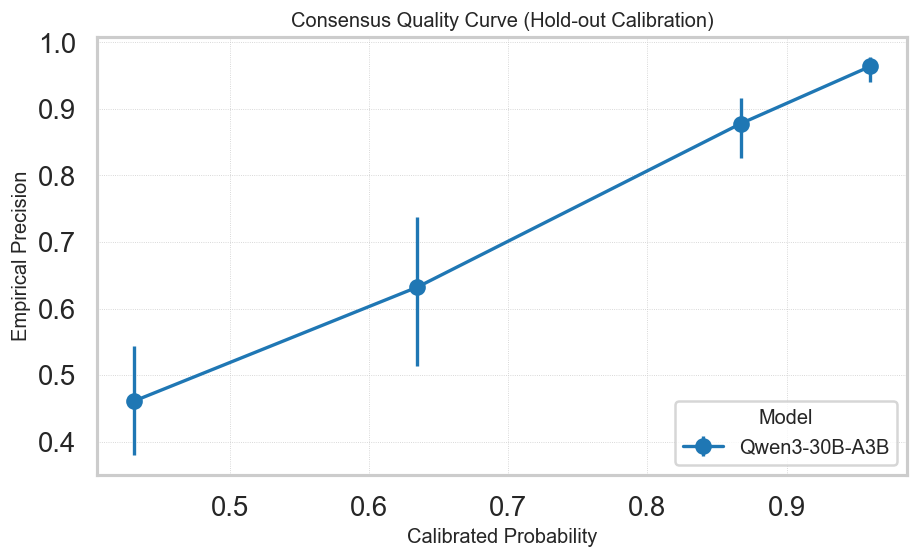

In [180]:
# A new code with dataset spli for isotonic regression and CI interval

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.proportion import proportion_confint

# Configuration
n_plot_bins = 2
plot_bins   = np.arange(0.0, 1.0001, 0.2)

plt.figure(figsize=(8, 5), dpi=120)

for (model_name, records), color in zip(cqc_data.items(), plt.cm.tab10.colors):
    # 1) Build the full dataframe
    df = pd.DataFrame(records, columns=[
        "probability", "is_correct", "value", "pii_type", "annotators", "document_id"
    ])
    df = df[(df["probability"] > 0.0) & (df["pii_type"] != "Signature")]

    # 2) Hold‐out split: calibration vs. evaluation
    calib_df, eval_df = train_test_split(
        df,
        test_size=0.5,        # use 50% to fit iso, 50% to evaluate
        random_state=42
    )

    # 3) Fit the isotonic calibrator on the calibration set
    iso = IsotonicRegression(out_of_bounds="clip")
    iso.fit(calib_df["probability"], calib_df["is_correct"])

    # 4) Apply calibration to the evaluation set
    eval_df = eval_df.copy()
    eval_df["prob_calib"] = iso.transform(eval_df["probability"].values)

    custom_bins =[0.0,0.1,0.2,0.3,0.4,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]

    # 5) Build final quality curve in fixed-width bins on eval set
    eval_df["bin_plot"] = pd.cut(eval_df["prob_calib"], bins=custom_bins, duplicates="drop")
    curve_df = eval_df.groupby("bin_plot").agg(
        probability = ("prob_calib", "mean"),
        is_correct  = ("is_correct", "mean"),
        count       = ("prob_calib", "count"),
        correct     = ("is_correct", "sum")
    ).reset_index()

    # 6) Drop empty bins
    curve_df = curve_df[curve_df["count"] > 0]

    # 7) Compute 95% Wilson CIs for each bin
    low, high = proportion_confint(
        count=curve_df["correct"],
        nobs=curve_df["count"],
        alpha=0.05,
        method="wilson"
    )
    curve_df["lower_ci"], curve_df["upper_ci"] = low, high

    # 8) Print the table
    print(f"\n=== {model_name} Consensus Quality Curve ===")
    print(curve_df[[
        "probability", "is_correct", "count", "lower_ci", "upper_ci"
    ]])

    # 9) Plot with error bars
    plt.errorbar(
        curve_df["probability"],
        curve_df["is_correct"],
        yerr=[
            curve_df["is_correct"] - curve_df["lower_ci"],
            curve_df["upper_ci"] - curve_df["is_correct"]
        ],
        fmt="o-",
        linewidth=2,
        color=color,
        label=model_name
    )

# Finalize plot
plt.xlabel("Calibrated Probability", fontsize=12)
plt.ylabel("Empirical Precision",   fontsize=12)
plt.title ("Consensus Quality Curve (Hold-out Calibration)", fontsize=12)
plt.grid(True, linestyle=":", linewidth=0.5)
plt.legend(title="Model", fontsize=12, title_fontsize=12, loc="lower right", frameon=True)
plt.tight_layout()
plt.show()


[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
     bin_plot  prob_center  accuracy    n    k    ci_low   ci_high
4  (0.4, 0.5]     0.406250  0.458904  146   67  0.380164  0.539751
5  (0.5, 0.6]     0.600000  0.500000   16    8  0.279996  0.720004
6  (0.6, 0.7]     0.666667  0.617284   81   50  0.508412  0.715535
8  (0.8, 0.9]     0.857840  0.883817  241  213  0.837208  0.918383
9  (0.9, 1.0]     0.958749  0.964435  478  461  0.943787  0.977678


/var/folders/g7/2mq549f93f560cdw0f0lx1j40000gn/T/ipykernel_33295/1119222055.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin_plot")


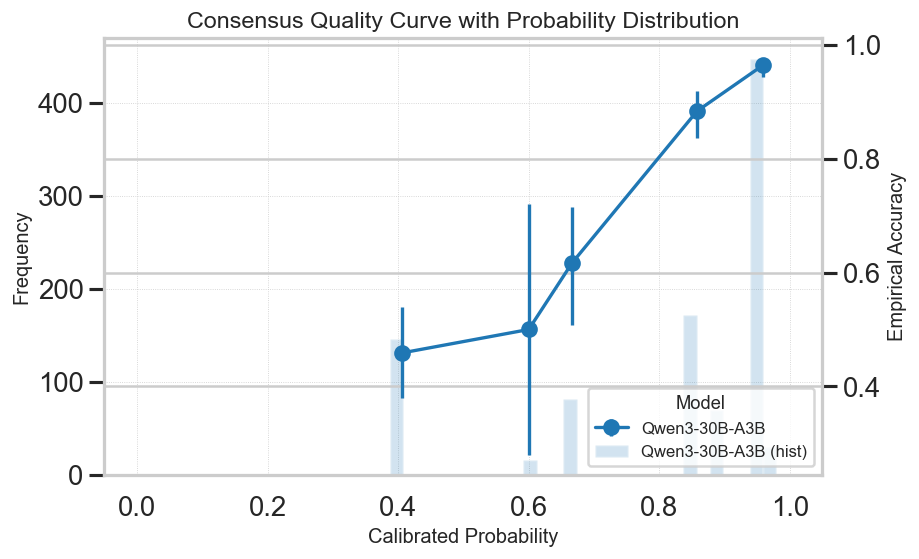

Use threshold: 0.9587486613700739


In [305]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.proportion import proportion_confint

# ─── Replace this with your actual data loading ───
# cqc_data = {
#     "Qwen3-30B-A3B": records_list_for_Qwen3, 
#     "AnotherModel": records_list_for_other_model,
#     # …
# }
# Each records_list is a list of rows: 
#   [probability, is_correct, value, pii_type, annotators, document_id]

# ─── Plotting setup ───
fig, ax_hist = plt.subplots(figsize=(8, 5), dpi=120)
ax_cal = ax_hist.twinx()
colors = plt.cm.tab10.colors

# ─── Loop over each model ───
for (model_name, records), color in zip(cqc_data.items(), colors):
    # 1) Build a DataFrame
    df = pd.DataFrame(records, columns=[
        "probability", "is_correct", "value",
        "pii_type", "annotators", "document_id"
    ])
    # filter out zero‐probs and signatures
    df = df[(df["probability"] > 0.0) & (df["pii_type"] != "Signature")]

    # 2) Split into calibration / evaluation halves
    calib_df, eval_df = train_test_split(df, test_size=0.6, random_state=42)

    # 3) Fit isotonic regression on the calibration set
    iso = IsotonicRegression(out_of_bounds="clip")
    iso.fit(calib_df["probability"], calib_df["is_correct"])

    # 4) Transform the evaluation set
    eval_df = eval_df.copy()
    eval_df["prob_calib"] = iso.transform(eval_df["probability"].values)

    # 5) Plot histogram of calibrated probabilities
    ax_hist.hist(
        eval_df["prob_calib"],
        bins=np.linspace(0,1,50),
        alpha=0.2, color=color,
        label=f"{model_name} (hist)"
    )

    # 6) Bin into fixed-width intervals
    custom_bins = np.arange(0.0, 1.0001, 0.1)
    print(custom_bins)
    eval_df["bin_plot"] = pd.cut(eval_df["prob_calib"], bins=custom_bins, duplicates="drop")

    # 7) Compute per-bin statistics
    curve_df = (
        eval_df
        .groupby("bin_plot")
        .agg(
            prob_center   = ("prob_calib","mean"),
            accuracy      = ("is_correct","mean"),
            n             = ("prob_calib","count"),
            k             = ("is_correct","sum")
        )
        .reset_index()
    )
    # drop empty
    curve_df = curve_df[curve_df["n"] > 0]

    # 8) Wilson CIs
    low, high = proportion_confint(curve_df["k"], curve_df["n"], method="wilson")
    curve_df["ci_low"], curve_df["ci_high"] = low, high

    print(curve_df)

    # 9) Overlay calibration curve
    yerr = [
        curve_df["accuracy"] - curve_df["ci_low"],
        curve_df["ci_high"] - curve_df["accuracy"]
    ]

    ax_cal.errorbar(
        curve_df["prob_center"],
        curve_df["accuracy"],
        yerr=yerr,
        fmt="o-",
        linewidth=2,
        color=color,
        label=model_name
    )

# ─── Finalize styling ───
ax_hist.set_xlabel("Calibrated Probability", fontsize=12)
ax_hist.set_ylabel("Frequency", fontsize=12)
ax_cal.set_ylabel("Empirical Accuracy", fontsize=12)
ax_hist.set_title("Consensus Quality Curve with Probability Distribution", fontsize=14)
ax_hist.grid(True, linestyle=":", linewidth=0.5)

# Merge legends from both axes
lines_hist, labs_hist = ax_hist.get_legend_handles_labels()
lines_cal,  labs_cal  = ax_cal .get_legend_handles_labels()
ax_cal.legend(lines_cal + lines_hist, labs_cal + labs_hist,
              title="Model", loc="lower right", fontsize=10, title_fontsize=11)

plt.tight_layout()
plt.show()

desired_prec = 0.85
good_bins = curve_df[curve_df['ci_low'] >= desired_prec]

# pick the lowest bin center among them
if not good_bins.empty:
    threshold = good_bins['prob_center'].min()
else:
    # no bin guarantees that precision — fallback to raw cutoff
    threshold = curve_df.loc[curve_df['accuracy'].idxmax(), 'prob_center']

print("Use threshold:", threshold)


[0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
        bin_plot  prob_center  accuracy    n    k    ci_low   ci_high
3   (0.375, 0.5]     0.430668  0.460993  141   65  0.380841  0.543213
5  (0.625, 0.75]     0.634615  0.632353   68   43  0.513556  0.736995
6  (0.75, 0.875]     0.857143  0.886667  150  133  0.825997  0.928026
7   (0.875, 1.0]     0.952115  0.950339  443  421  0.925956  0.966979


/var/folders/g7/2mq549f93f560cdw0f0lx1j40000gn/T/ipykernel_33295/3735225693.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin_plot")


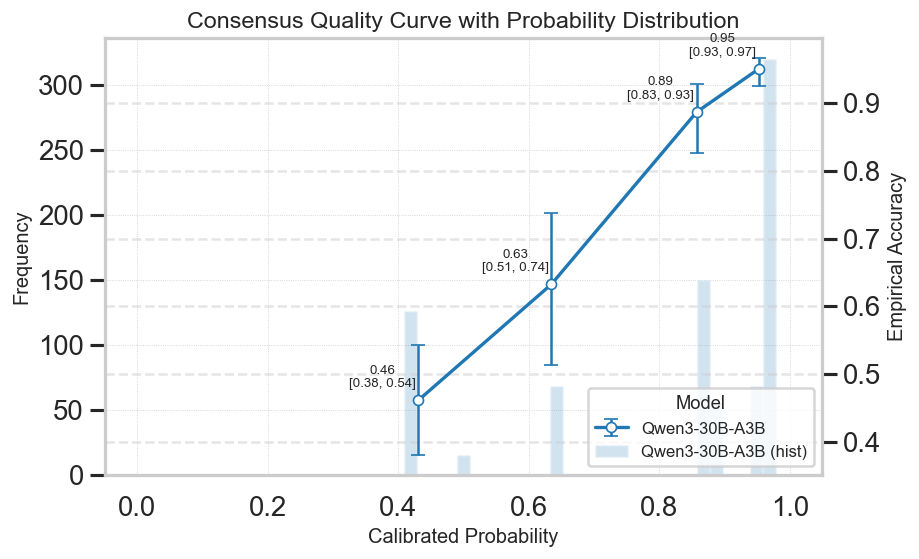

Use threshold: 0.857142857142857
593
Recall Rate : 0.8368580060422961


In [398]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.proportion import proportion_confint

# ─── Replace this with your actual data loading ───
# cqc_data = {
#     "Qwen3-30B-A3B": records_list_for_Qwen3, 
#     "AnotherModel": records_list_for_other_model,
#     # …
# }
# Each records_list is a list of rows: 
#   [probability, is_correct, value, pii_type, annotators, document_id]

# ─── Plotting setup ───
fig, ax_hist = plt.subplots(figsize=(8, 5), dpi=120)
ax_cal = ax_hist.twinx()
colors = plt.cm.tab10.colors

# ─── Loop over each model ───
for (model_name, records), color in zip(cqc_data.items(), colors):
    # 1) Build a DataFrame
    df = pd.DataFrame(records, columns=[
        "probability", "is_correct", "value",
        "pii_type", "annotators", "document_id"
    ])
    # filter out zero‐probs and signatures
    df = df[(df["probability"] > 0.0) & (df["pii_type"] != "Signature")]

    # 2) Split into calibration / evaluation halves
    calib_df, eval_df = train_test_split(df, test_size=0.50, random_state=42)

    # 3) Fit isotonic regression on the calibration set
    iso = IsotonicRegression(out_of_bounds="clip")
    iso.fit(calib_df["probability"], calib_df["is_correct"])

    # 4) Transform the evaluation set
    eval_df = eval_df.copy()
    eval_df["prob_calib"] = iso.transform(eval_df["probability"].values)

    # import matplotlib.pyplot as plt
    # plt.hist(calib_df["probability"], bins=50, alpha=0.5, label="train set", color="red")
    # plt.hist(eval_df["prob_calib"], bins=50, alpha=0.8, label="test set")
    # plt.legend(); plt.show()

    # 5) Plot histogram of calibrated probabilities
    ax_hist.hist(
        eval_df["prob_calib"],
        bins=np.linspace(0,1,50),
        alpha=0.2, color=color,
        label=f"{model_name} (hist)"
    )

    # 6) Bin into fixed-width intervals
    custom_bins = np.arange(0.0, 1.0001, 0.125)
    print(custom_bins)
    eval_df["bin_plot"] = pd.cut(eval_df["prob_calib"], bins=custom_bins, duplicates="drop")

    # 7) Compute per-bin statistics
    curve_df = (
        eval_df
        .groupby("bin_plot")
        .agg(
            prob_center   = ("prob_calib","mean"),
            accuracy      = ("is_correct","mean"),
            n             = ("prob_calib","count"),
            k             = ("is_correct","sum")
        )
        .reset_index()
    )
    # drop empty
    curve_df = curve_df[curve_df["n"] > 0]

    # 8) Wilson CIs
    low, high = proportion_confint(curve_df["k"], curve_df["n"], method="wilson")
    curve_df["ci_low"], curve_df["ci_high"] = low, high

    print(curve_df)

    # 9) Overlay calibration curve
    yerr = [
        curve_df["accuracy"] - curve_df["ci_low"],
        curve_df["ci_high"] - curve_df["accuracy"]
    ]

    # ax_cal.errorbar(
    #     curve_df["prob_center"],
    #     curve_df["accuracy"],
    #     yerr=yerr,
    #     fmt="o-",
    #     linewidth=2,
    #     color=color,
    #     label=model_name
    # )

    ax_cal.errorbar(
    curve_df["prob_center"],
    curve_df["accuracy"],
    yerr=yerr,
    fmt="o-",                # Circle marker and solid line
    linewidth=2,
    color=color,
    label=model_name,
    capsize=4,               # Adds caps to the error bars
    elinewidth=1.5,          # Thickness of the error bar line
    markerfacecolor='white', # Better contrast on markers
    markersize=6             # Slightly larger markers
)

    # Annotate each point with its accuracy value
    for i in range(len(curve_df)):
        x = curve_df["prob_center"].iloc[i]
        y = curve_df["accuracy"].iloc[i]
        ci_low = curve_df["ci_low"].iloc[i]
        ci_high = curve_df["ci_high"].iloc[i]
        ax_cal.text(
            x - 0.055, y + 0.015,
            f"{y:.2f}\n[{ci_low:.2f}, {ci_high:.2f}]",
            ha="center", va="bottom", fontsize=8
        )

    # Optional: Add grid for readability
    ax_cal.grid(True, linestyle='--', alpha=0.5)

# ─── Finalize styling ───
ax_hist.set_xlabel("Calibrated Probability", fontsize=12)
ax_hist.set_ylabel("Frequency", fontsize=12)
ax_cal.set_ylabel("Empirical Accuracy", fontsize=12)
ax_hist.set_title("Consensus Quality Curve with Probability Distribution", fontsize=14)
ax_hist.grid(True, linestyle=":", linewidth=0.5)

# Merge legends from both axes
lines_hist, labs_hist = ax_hist.get_legend_handles_labels()
lines_cal,  labs_cal  = ax_cal .get_legend_handles_labels()
ax_cal.legend(lines_cal + lines_hist, labs_cal + labs_hist,
              title="Model", loc="lower right", fontsize=10, title_fontsize=11)

plt.tight_layout()
plt.show()


desired_prec = 0.80
good_bins = curve_df[curve_df['ci_low'] >= desired_prec]

# pick the lowest bin center among them
if not good_bins.empty:
    threshold = good_bins['prob_center'].min()
else:
    # no bin guarantees that precision — fallback to raw cutoff
    threshold = curve_df.loc[curve_df['accuracy'].idxmax(), 'prob_center']

print("Use threshold:", threshold)

print(len(eval_df[eval_df['prob_calib'] >= threshold]))
recall_rate = len(eval_df[eval_df['prob_calib'] >= threshold]) / 662

total_gt = 662

mask = eval_df["prob_calib"] >= threshold
tp = eval_df.loc[mask, "is_correct"].sum()
rec = tp / total_gt if total_gt > 0 else 0.0

print(f"Recall Rate : {rec}")


In [399]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(eval_df[(eval_df['is_correct'] == False) & (eval_df['prob_calib'] > threshold)])

      probability  is_correct  \
374      0.994758       False   
494      0.973623       False   
1140     0.994758       False   
1128     0.921972       False   
495      0.973623       False   
123      0.999887       False   
1217     0.999887       False   
306      0.998841       False   
433      0.999822       False   
1418     0.973623       False   
259      0.973623       False   
1301     0.999822       False   
240      0.994758       False   
1216     0.999887       False   
693      0.998841       False   
1165     0.994758       False   
1173     0.999483       False   
493      0.973623       False   
707      0.998841       False   
292      0.999793       False   
1164     0.998841       False   
1462     0.999793       False   
435      0.999822       False   
126      0.999887       False   
1179     0.994758       False   
1192     0.941395       False   
129      0.994758       False   
589      0.999887       False   
131      0.999793       False   
984      0

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
     bin_plot  prob_center  accuracy    n    k    ci_low   ci_high
4  (0.4, 0.5]     0.430668  0.460993  141   65  0.380841  0.543213
6  (0.6, 0.7]     0.634615  0.632353   68   43  0.513556  0.736995
8  (0.8, 0.9]     0.867229  0.878049  205  180  0.826173  0.916017
9  (0.9, 1.0]     0.960249  0.963918  388  374  0.940352  0.978387


/var/folders/g7/2mq549f93f560cdw0f0lx1j40000gn/T/ipykernel_33295/2685369017.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bin_plot")


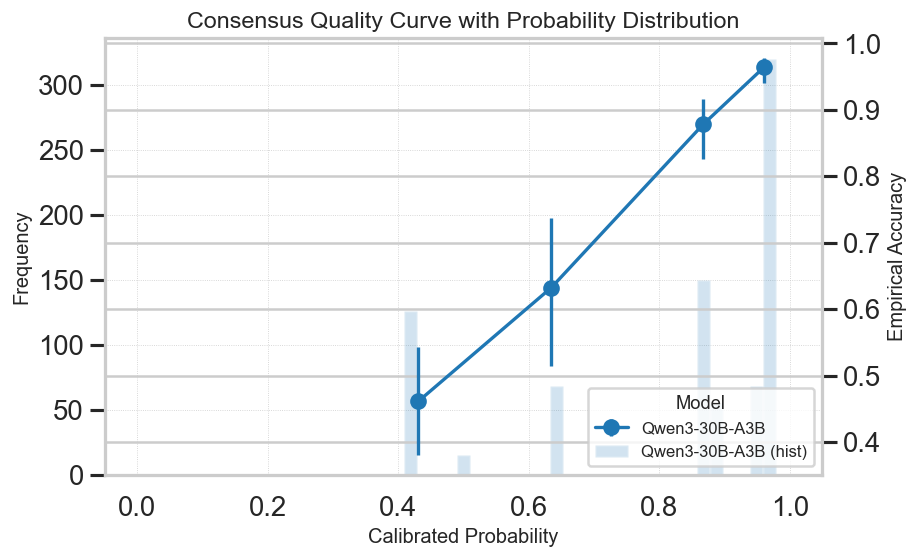

In [265]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.proportion import proportion_confint

# ─── Replace this with your actual data loading ───
# cqc_data = {
#     "Qwen3-30B-A3B": records_list_for_Qwen3, 
#     "AnotherModel": records_list_for_other_model,
#     # …
# }
# Each records_list is a list of rows: 
#   [probability, is_correct, value, pii_type, annotators, document_id]

# ─── Plotting setup ───
fig, ax_hist = plt.subplots(figsize=(8, 5), dpi=120)
ax_cal = ax_hist.twinx()
colors = plt.cm.tab10.colors

# ─── Loop over each model ───
for (model_name, records), color in zip(cqc_data.items(), colors):
    # 1) Build a DataFrame
    df = pd.DataFrame(records, columns=[
        "probability", "is_correct", "value",
        "pii_type", "annotators", "document_id"
    ])
    # filter out zero‐probs and signatures
    df = df[(df["probability"] > 0.0) & (df["pii_type"] != "Signature")]

    # 2) Split into calibration / evaluation halves
    calib_df, eval_df = train_test_split(df, test_size=0.5, random_state=42)

    # 3) Fit isotonic regression on the calibration set
    iso = IsotonicRegression(out_of_bounds="clip")
    iso.fit(calib_df["probability"], calib_df["is_correct"])

    # 4) Transform the evaluation set
    eval_df = eval_df.copy()
    eval_df["prob_calib"] = iso.transform(eval_df["probability"].values)

    # import matplotlib.pyplot as plt
    # plt.hist(calib_df["probability"], bins=50, alpha=0.5, label="train set", color="red")
    # plt.hist(eval_df["prob_calib"], bins=50, alpha=0.8, label="test set")
    # plt.legend(); plt.show()

    # 5) Plot histogram of calibrated probabilities
    ax_hist.hist(
        eval_df["prob_calib"],
        bins=np.linspace(0,1,50),
        alpha=0.2, color=color,
        label=f"{model_name} (hist)"
    )

    # 6) Bin into fixed-width intervals
    custom_bins = np.arange(0.0, 1.0001, 0.1)
    print(custom_bins)
    eval_df["bin_plot"] = pd.cut(eval_df["prob_calib"], bins=custom_bins, duplicates="drop")

    # 7) Compute per-bin statistics
    curve_df = (
        eval_df
        .groupby("bin_plot")
        .agg(
            prob_center   = ("prob_calib","mean"),
            accuracy      = ("is_correct","mean"),
            n             = ("prob_calib","count"),
            k             = ("is_correct","sum")
        )
        .reset_index()
    )
    # drop empty
    curve_df = curve_df[curve_df["n"] > 0]

    # 8) Wilson CIs
    low, high = proportion_confint(curve_df["k"], curve_df["n"], method="wilson")
    curve_df["ci_low"], curve_df["ci_high"] = low, high

    print(curve_df)

    # 9) Overlay calibration curve
    yerr = [
        curve_df["accuracy"] - curve_df["ci_low"],
        curve_df["ci_high"] - curve_df["accuracy"]
    ]

    ax_cal.errorbar(
        curve_df["prob_center"],
        curve_df["accuracy"],
        yerr=yerr,
        fmt="o-",
        linewidth=2,
        color=color,
        label=model_name
    )

# ─── Finalize styling ───
ax_hist.set_xlabel("Calibrated Probability", fontsize=12)
ax_hist.set_ylabel("Frequency", fontsize=12)
ax_cal.set_ylabel("Empirical Accuracy", fontsize=12)
ax_hist.set_title("Consensus Quality Curve with Probability Distribution", fontsize=14)
ax_hist.grid(True, linestyle=":", linewidth=0.5)

# Merge legends from both axes
lines_hist, labs_hist = ax_hist.get_legend_handles_labels()
lines_cal,  labs_cal  = ax_cal .get_legend_handles_labels()
ax_cal.legend(lines_cal + lines_hist, labs_cal + labs_hist,
              title="Model", loc="lower right", fontsize=10, title_fontsize=11)

plt.tight_layout()
plt.show()


/var/folders/g7/2mq549f93f560cdw0f0lx1j40000gn/T/ipykernel_33295/2493223543.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for b, grp in df_boot.groupby('bin'):



=== Qwen3-30B-A3B Calibration with Doc-Level CIs ===
       bin  probability  precision  lower_ci  upper_ci  count
(0.4, 0.6]     0.430668   0.460993  0.364261  0.577788    141
(0.6, 0.8]     0.634615   0.632353  0.455708  0.788185     68
(0.8, 1.0]     0.928092   0.934233  0.909006  0.959361    593


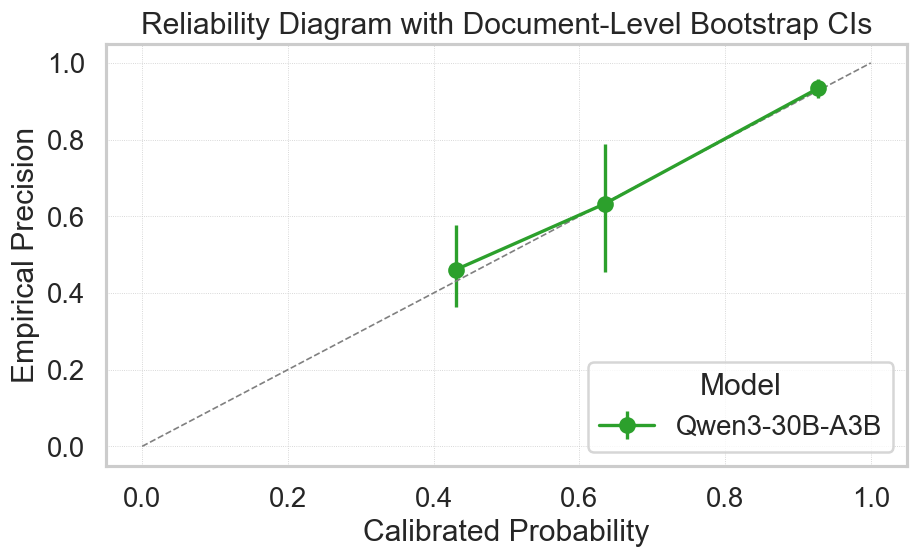

In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split

def document_bootstrap_ci(eval_df, doc_id_col='document_id', bins=None, n_boot=500, alpha=0.05, random_state=None):
    rng = np.random.default_rng(random_state)
    if bins is None:
        eval_df['bin'] = pd.qcut(eval_df['prob_calib'], q=10, duplicates='drop')
    else:
        eval_df['bin'] = pd.cut(eval_df['prob_calib'], bins=bins, include_lowest=True)
    docs = list(eval_df.groupby(doc_id_col))
    _, doc_groups = zip(*docs)
    bin_categories = eval_df['bin'].cat.categories
    boot_prec = {b: [] for b in bin_categories}
    for _ in range(n_boot):
        idxs = rng.integers(0, len(doc_groups), size=len(doc_groups))
        sampled = [doc_groups[i] for i in idxs]
        df_boot = pd.concat(sampled, axis=0)
        if bins is None:
            df_boot['bin'] = pd.qcut(df_boot['prob_calib'], q=10, duplicates='drop')
        else:
            df_boot['bin'] = pd.cut(df_boot['prob_calib'], bins=bins, include_lowest=True)
        for b, grp in df_boot.groupby('bin'):
            if len(grp):
                boot_prec[b].append(grp['is_correct'].mean())
    rows = []
    for b in bin_categories:
        grp = eval_df[eval_df['bin'] == b]
        if grp.empty: continue
        p_mean = grp['is_correct'].mean()
        cnt    = len(grp)
        lo = np.percentile(boot_prec[b], 100 * (alpha/2))
        hi = np.percentile(boot_prec[b], 100 * (1 - alpha/2))
        rows.append({
            'bin': b,
            'probability': grp['prob_calib'].mean(),
            'precision': p_mean,
            'lower_ci': lo,
            'upper_ci': hi,
            'count': cnt
        })
    return pd.DataFrame(rows)

# --- Configuration ---
PLOT_BINS    = np.linspace(0, 1, 6)    # e.g. [0.,0.2,...,1.]
CALIB_SPLIT  = 0.5
N_BOOTSTRAPS = 500
SEED         = 42

plt.figure(figsize=(8, 5), dpi=120)

for (model_name, records), color in zip(cqc_data.items(), plt.cm.tab10.colors):
    # Build DataFrame (ensure each record ends with the document_id)
    df = pd.DataFrame(records, columns=[
        "probability", "is_correct", "value", "pii_type", "annotators", "document_id"
    ])
    df = df[(df.probability > 0) & (df.pii_type != "Signature")]

    # Split
    calib_df, eval_df = train_test_split(df, test_size=CALIB_SPLIT, random_state=SEED)

    # Calibrate
    iso = IsotonicRegression(out_of_bounds="clip")
    iso.fit(calib_df.probability, calib_df.is_correct)
    eval_df = eval_df.copy()
    eval_df["prob_calib"] = iso.transform(eval_df.probability)

    # Compute doc-level CIs
    ci_df = document_bootstrap_ci(
        eval_df,
        doc_id_col="document_id",
        bins=PLOT_BINS,
        n_boot=N_BOOTSTRAPS,
        alpha=0.05,
        random_state=SEED
    )

    # Print
    print(f"\n=== {model_name} Calibration with Doc-Level CIs ===")
    print(ci_df.to_string(index=False))

    # Plot
    plt.errorbar(
        ci_df.probability,
        ci_df.precision,
        yerr=[ci_df.precision - ci_df.lower_ci,
              ci_df.upper_ci  - ci_df.precision],
        fmt="o-",
        linewidth=2,
        label=model_name
    )

plt.plot([0, 1], [0, 1], "--", color="gray", linewidth=1)
plt.xlabel("Calibrated Probability")
plt.ylabel("Empirical Precision")
plt.title("Reliability Diagram with Document-Level Bootstrap CIs")
plt.grid(True, linestyle=":", linewidth=0.5)
plt.legend(title="Model", loc="lower right")
plt.tight_layout()
plt.show()


In [175]:
qwen_model_extractions = cqc_data['Qwen3-30B-A3B']

qwen_model_extractions_df = pd.DataFrame(qwen_model_extractions, columns=[ "probability", "is_correct", "value", "pii_type", "annotators", "document_id"])
# print(qwen_model_extractions_df)

qwen_model_extractions_df = qwen_model_extractions_df[(qwen_model_extractions_df['is_correct'] == True)]
print(qwen_model_extractions_df)

# 2. Compute per‐document statistics on the probability scores
doc_stats = (
    qwen_model_extractions_df
    .groupby('document_id')['probability']
    .agg(
        count='count',
        mean='mean',
        std='std'
    )
    .reset_index()
)

print(doc_stats)

# 3. Print summary of how many extractions per document
print("Per-document extraction counts:")
print(doc_stats['count'].describe().to_string())

# 4. Print summary of per-document mean probabilities
print("\nPer-document mean probabilities:")
print(doc_stats['mean'].describe().to_string())

# 5. Compute overall SD of those per-doc means
print(f"\nStd dev of document mean probabilities: {doc_stats['mean'].std():.3f}")



# 3. Between‐document SD
between_sd = doc_stats['mean'].std()

# 4. Total SD of all probabilities
total_sd = df['probability'].std()

print(f"Between‐doc SD: {between_sd:.3f}")
print(f"Total SD:       {total_sd:.3f}")
print(f"Frac. of var. due to docs: {between_sd**2/total_sd**2:.2%}")


      probability  is_correct                      value         pii_type  \
0        0.999822        True             Dr. H. s. Tong      Person Name   
1        0.999793        True           October 15, 1972             Date   
2        0.562665        True                    H-102-5  Contract Number   
7        0.998841        True            Kansas City, KS         Location   
8        0.904109        True                    Wichita         Location   
...           ...         ...                        ...              ...   
1598     0.999822        True  Timothy M. Finnegan, Esq.      Person Name   
1599     0.999822        True             Frank G. Colby      Person Name   
1600     0.999822        True            Max Crohn, Esq.      Person Name   
1601     0.999822        True        Dr. Charles Nystrom      Person Name   
1602     0.999793        True              June 23, 1983             Date   

     annotators          document_id  
0     [0, 1, 2]  fhfb0066_page1.json

0.4224137931034483
662
[0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95
 1.  ]
At t = 0.3, coverage : 1.0, recall : 1.0,
At t = 0.35, coverage : 1.0, recall : 1.0,
At t = 0.39999999999999997, coverage : 1.0, recall : 1.0,
At t = 0.44999999999999996, coverage : 0.8428927680798005, recall : 0.9138972809667674,
At t = 0.49999999999999994, coverage : 0.8428927680798005, recall : 0.9138972809667674,
At t = 0.5499999999999999, coverage : 0.8241895261845387, recall : 0.9018126888217523,
At t = 0.5999999999999999, coverage : 0.8241895261845387, recall : 0.9018126888217523,
At t = 0.6499999999999999, coverage : 0.7394014962593516, recall : 0.8368580060422961,
At t = 0.7, coverage : 0.7394014962593516, recall : 0.8368580060422961,
At t = 0.7499999999999999, coverage : 0.7394014962593516, recall : 0.8368580060422961,
At t = 0.7999999999999998, coverage : 0.7394014962593516, recall : 0.8368580060422961,
At t = 0.8499999999999999, coverage : 0.7394014962593516, recall : 0.8368

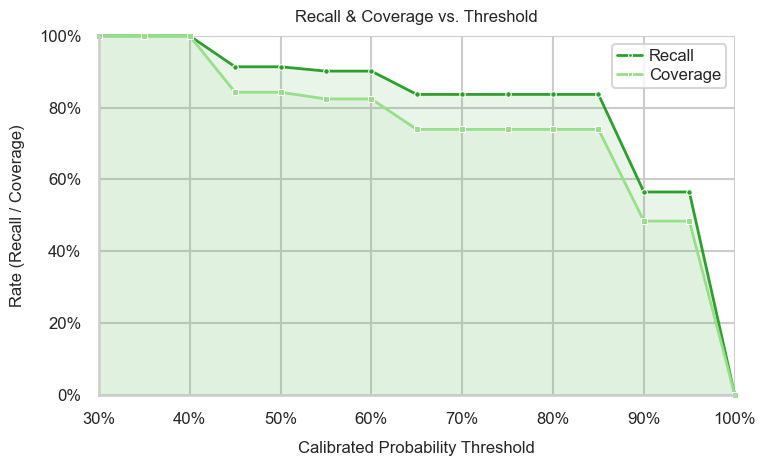

In [370]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick
from matplotlib.ticker import MultipleLocator


print(eval_df['prob_calib'].min())


# Compute total number of ground-truth spans
# (these are the spans you want to recover)
total_gt = len(eval_df[eval_df['is_correct'] == True]) # e.g. from len(ground_truth_list)
print(total_gt)
# Choose a grid of thresholds (you can also use your bin edges)
thresholds = np.linspace(eval_df["prob_calib"].min(),
                         eval_df["prob_calib"].max(), 25)

thresholds = np.arange(0.3, 1.0001, 0.05)

print(thresholds)

coverage = []
recall   = []
precision = []  # optional, if you want to plot precision as well

for t in thresholds:
    # Which predictions we'd keep at this threshold
    mask = eval_df["prob_calib"] >= t
    # Coverage = fraction of all *predictions* kept
    cov = mask.mean()
    coverage.append(cov)
    
    # True positives = how many GT spans we matched at or above this threshold
    tp = eval_df.loc[mask, "is_correct"].sum()
    
    # Recall = TP / total number of GT spans
    rec = tp / total_gt if total_gt > 0 else 0.0
    recall.append(rec)

    print(f"At t = {t}, coverage : {cov}, recall : {rec},")
    
    # Precision = TP / (TP + FP) = TP / #kept
    prec = tp / mask.sum() if mask.sum() > 0 else 0.0
    precision.append(prec)

print(coverage)
print(recall)

sns.set_theme(context="talk", style="whitegrid", palette=["#2ca02c", "#98df8a"])

fig, ax = plt.subplots(figsize=(8, 5), dpi=100)

# Plot Recall
sns.lineplot(
    x=thresholds, y=recall, 
    marker="o", markersize=4, linewidth=2,
    label="Recall", ax=ax, clip_on=False
)
# Plot Coverage
sns.lineplot(
    x=thresholds, y=coverage, 
    marker="s", markersize=4, linewidth=2,
    label="Coverage", ax=ax, clip_on=False
)

ax.margins(x=0)


for (t,v) in zip(thresholds, recall):
    print(f"At T={t}, Recall : {v}") 

# Fill between
ax.fill_between(thresholds, recall, alpha=0.1)
ax.fill_between(thresholds, coverage, alpha=0.1)

# Format axes as percentage
ax.set_xlim(thresholds.min(), 1)

# Re-add the 100% tick
# ticks = list(ax.get_xticks())
# for t in [0.30, 1.00]:
#     if t not in ticks:
#         ticks.append(t)
# ax.set_xticks(sorted(ticks))


ax.set_ylim(0, 1.0)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0, symbol='%'))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, symbol='%'))

ax.tick_params(axis='both', which='major', labelsize=12, width=1)

# Labels, title, legend
ax.set_xlabel("Calibrated Probability Threshold", labelpad=10, fontsize=12)
ax.set_ylabel("Rate (Recall / Coverage)", labelpad=10, fontsize=12)
ax.set_title("Recall & Coverage vs. Threshold", pad=10, fontsize=12)
ax.legend(facecolor="white", edgecolor=".8", frameon=True,fontsize="12",markerscale=0.7, handlelength=1.5, handletextpad=0.4, borderpad=0.3, labelspacing=0.2)

# Tidy up the spines
sns.despine(trim=True)

plt.tight_layout()
plt.show()


In [ ]:
print(iso.transform([0.904109,0.56]))

In [ ]:
plt.hist(probs, bins=10, edgecolor='black')
plt.title("Distribution of Agreement Probabilities")
plt.xlabel("Agreement Score")
plt.ylabel("Count")

In [ ]:
# Show all rows and columns
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Prevent line breaks for wide columns (as much as terminal width allows)
pd.set_option('display.width', 1000)        # Increase this if needed
pd.set_option('display.expand_frame_repr', False)

#print(df)
# print(df[df['is_correct'] == False & df['annotators'].apply(lambda x: x == [0,1,2])])
print(df[(df['is_correct'] == False) & (df['prob_calibrated'] > 0.3) & (df['prob_calibrated'] <=0.5)])

In [ ]:
boxa = [
            725,
            983,
            2141,
            2016
        ]
boxb = [
      725,
      983,
      1415,
      1032
    ]

print(bb_intersection_over_union(boxa, boxb))

In [ ]:
sim = textdistance.jaro("Male", "male")
print(sim)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint

# ── 1) Example DataFrame ─────────────────────────────────────────────────────────
# Suppose “records” is your list of [probability, is_correct, pii_type, annotators]
# For illustration, let’s build a dummy DataFrame with most p in [0.95, 1.0].
np.random.seed(0)
N = 2000
# Draw 1800 points around 0.97–1.00, and 200 points uniformly in [0.90,0.95) for some spread
p_tail_heavy = np.concatenate([
    np.random.rand(1800) * 0.03 + 0.97,    # ~ uniform in [0.97,1.00]
    np.random.rand(200)  * 0.05 + 0.90     # ~ uniform in [0.90,0.95)
])
p_tail_heavy = np.clip(p_tail_heavy, 0.0, 1.0)
# Let is_correct be a random 0/1 with some arbitrary calibration-like behavior:
y = (np.random.rand(N) < (p_tail_heavy**2)).astype(int)

df = pd.DataFrame({
    "probability": p_tail_heavy,
    "is_correct":  y
})
# ── 2) Restrict to [0.95, 1.0] ─────────────────────────────────────────────────────
df = df[df["probability"] >= 0.95].reset_index(drop=True)

# ── 3) Choose Q = number of quantile‐bins across [0.95, 1.0] ────────────────────────
Q = 8  # for example, change to whatever ensures ~200 samples/bin
# If you want “roughly N/200” per bin, do: Q = max(1, len(df)//200)

# 3.1) Create a new “bin” column via pd.qcut on the restricted region
df["bin"] = pd.qcut(df["probability"], q=Q, duplicates="drop")

# 3.2) For reference, extract the numeric midpoint of each interval (shared across bins):
bin_intervals = df["bin"].cat.categories
bin_midpoints = np.array([interval.mid for interval in bin_intervals])

# ── 4) Compute per‐bin statistics (mean p, fraction correct, count, num_correct, Wilson CI) ──
agg = (
    df
    .groupby("bin")
    .agg(
        prob_mean   = ("probability", "mean"),   # x‐coordinate
        acc_mean    = ("is_correct",  "mean"),    # y‐coordinate
        count       = ("probability", "count"),   # n_j
        num_correct = ("is_correct",  "sum")      # k_j
    )
    .reset_index()
)
# Drop any bin that somehow ended with zero points (unlikely if Q is chosen well)
agg = agg[agg["count"] > 0].copy()

# 4.1) Compute 95% Wilson CI for each bin
ci_low, ci_up = [], []
for _, row in agg.iterrows():
    k = int(row["num_correct"])
    n = int(row["count"])
    low, up = proportion_confint(count=k, nobs=n, alpha=0.05, method="wilson")
    ci_low.append(low)
    ci_up.append(up)
agg["ci_lower"] = ci_low
agg["ci_upper"] = ci_up

# ── 5) Plot “mean p vs. empirical accuracy” with 95% CI, zoomed to [0.95,1.0] ──────────
plt.figure(figsize=(7, 4.5))

plt.errorbar(
    x      = agg["prob_mean"],
    y      = agg["acc_mean"],
    yerr   = [agg["acc_mean"] - agg["ci_lower"], agg["ci_upper"] - agg["acc_mean"]],
    fmt    = "o-",      # circle + line to connect points
    capsize= 3,
    color  = "C0",
    label  = "Binned accuracy ± 95% CI"
)

# Overlay the ideal diagonal y = x (zoomed to [0.95,1.0])
plt.plot([0.95, 1.0], [0.95, 1.0], "--", color="gray", label="Ideal (y=x)")

plt.xlabel("Predicted Probability", fontsize=11)
plt.ylabel("Empirical Accuracy", fontsize=11)
plt.title("Calibration in [0.95–1.00] (Quantile Bins, 95% Wilson CIs)", fontsize=13)
plt.xlim(0.95, 1.00)
plt.ylim(0.0, 1.0)
plt.grid(True, linestyle=":", alpha=0.6)
plt.legend(loc="lower right", fontsize=9)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# Your real data here
thresholds = np.linspace(0.32, 0.99, 8)
recall     = np.array([0.80, 0.75, 0.76, 0.75, 0.73, 0.69, 0.68, 0.53])
coverage   = np.array([1.00, 0.93, 0.89, 0.88, 0.83, 0.76, 0.73, 0.58])

# 1) Seaborn whitegrid with green palette
sns.set_theme(context="talk", style="whitegrid", palette=["#2ca02c", "#98df8a"])

# 2) Figure size & DPI
fig, ax = plt.subplots(figsize=(9, 5), dpi=150)

# 3) Plot lines in shades of green
ax.plot(
    thresholds, recall,
    label="Recall",
    color="#2ca02c",      # dark green
    linewidth=3,
    marker="o",           # circle marker
    markersize=8
)
ax.plot(
    thresholds, coverage,
    label="Coverage",
    color="#98df8a",      # light green
    linewidth=3,
    marker="s",           # square marker
    markersize=8
)

# 4) No area fill (kept transparent)

# 5) Percent formatting
ax.set_xlim(0.30, 1.00)
ax.set_ylim(0.30, 1.02)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0, 0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, 0))

# 6) Labels and title with larger fonts
ax.set_xlabel("Calibrated Probability Threshold", fontsize=16, labelpad=12)
ax.set_ylabel("Rate (Recall / Coverage)",            fontsize=16, labelpad=12)
ax.set_title("Recall & Coverage vs. Threshold",      fontsize=18, pad=16)

# 7) Legend styling
leg = ax.legend(loc="upper right", frameon=True, facecolor="white", edgecolor="#cccccc", fontsize=14)
for text in leg.get_texts():
    text.set_color("#333333")

# 8) Tidy spines
sns.despine(trim=True)

# 9) Tick parameters
ax.tick_params(axis="both", which="major", labelsize=14, width=1)

plt.tight_layout()
plt.show()


Model : Qwen3-30B-A3B , P: 0.8677443056576047, R: 0.7192448233861145, F1 : 0.7865467865467866
Model : Qwen3-4B , P: 0.7254480286738352, R: 0.6163215590742996, F1 : 0.6664471517945341
Model : qwen2_5_72b , P: 0.6986842105263158, R: 0.3233861144945189, F1 : 0.4421315570358035
Model : qwen2_5_32b , P: 0.8398876404494382, R: 0.546285018270402, F1 : 0.6619926199261993
Model : Llama-3.3-70B , P: 0.774822695035461, R: 0.2661388550548112, F1 : 0.39619220308250225
Model : Gemma3-4B-it , P: 0.4083769633507853, R: 0.1900121802679659, F1 : 0.2593516209476309
Model : Gemma3-27B-it , P: 0.7257383966244726, R: 0.5237515225334958, F1 : 0.60841881853555


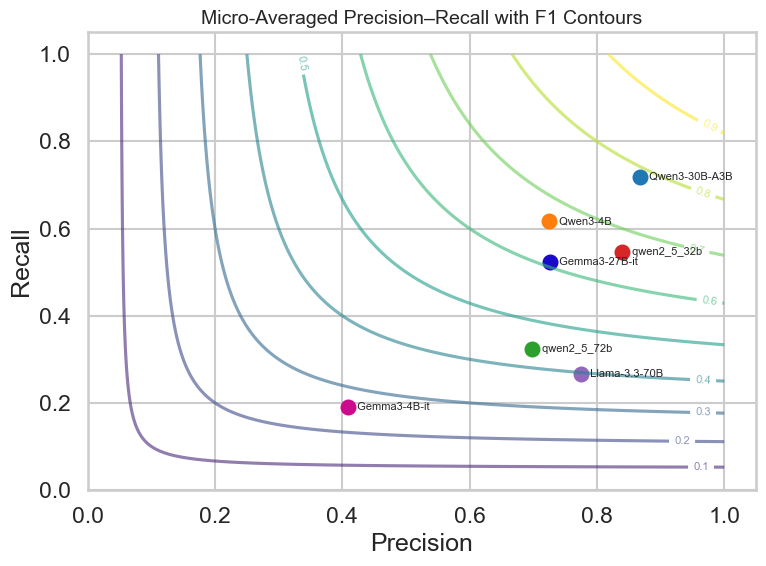

In [148]:
import matplotlib.pyplot as plt
import numpy as np
import json

def extract_metrics(json_path):
    """
    Load the input JSON and extract only the tp, fp, fn from each model's value_metrics.
    Returns a dict in the same structure as your desired metrics_json.
    """
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    extracted = {}
    for model_name, model_info in data.items():
        vm = model_info.get("value_metrics", {})
        extracted[model_name] = {"value_metrics": {}}
        for field, metrics in vm.items():
            extracted[model_name]["value_metrics"][field] = {
                "tp": metrics.get("tp", 0),
                "fp": metrics.get("fp", 0),
                "fn": metrics.get("fn", 0),
            }
    return extracted


# Parse JSON
metrics = extract_metrics("/Volumes/MyDataDrive/thesis/code-2/src/weak-labels-algo/all-model-f1-score.json")

# Compute micro-Precision, micro-Recall, micro-F1 per model
micro = {}
for model, data in metrics.items():
    tp = sum(em['tp'] for em in data['value_metrics'].values())
    fp = sum(em['fp'] for em in data['value_metrics'].values())
    fn = sum(em['fn'] for em in data['value_metrics'].values())
    p = tp / (tp + fp) if (tp + fp) else 0
    r = tp / (tp + fn) if (tp + fn) else 0
    f1 = 2 * p * r / (p + r) if (p + r) else 0
    micro[model] = (p, r, f1)

    print(f"Model : {model} , P: {p}, R: {r}, F1 : {f1}")

# Precision-Recall grid for F1 contours
x = np.linspace(0.01, 1, 300)
y = np.linspace(0.01, 1, 300)
X, Y = np.meshgrid(x, y)
F1_grid = 2 * X * Y / (X + Y)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
contours = ax.contour(X, Y, F1_grid, levels=np.arange(0.0, 1.0, 0.1), cmap='viridis', alpha=0.6)
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f')

colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd', "#cc0a8c", "#1a0acc"]
ci = 0
import random

# Scatter points with labels
for model, (p, r, f1) in micro.items():
    ax.scatter(p, r, s=100, color=colors[ci])
    ci = ci+1
    ax.text(p + 0.01, r, f" {model}", fontsize=8, va='center')

# Labels and styling
ax.set_title("Micro-Averaged Precision–Recall with F1 Contours", fontsize=14)
ax.set_xlabel("Precision")
ax.set_ylabel("Recall")
ax.set_xlim(0, 1.05)
ax.set_ylim(0, 1.05)
ax.grid(True)

plt.tight_layout()
plt.show()
